In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def entropy(self, y):
        """Calculate the entropy of a label distribution."""
        unique_classes, counts = np.unique(y, return_counts=True)
        probabilities = counts / counts.sum()
        entropy = -np.sum(probabilities * np.log2(probabilities))
        return entropy

    def information_gain(self, y, y_left, y_right):
        """Calculate the information gain of a split."""
        p = len(y_left) / len(y)
        gain = self.entropy(y) - (p * self.entropy(y_left) + (1 - p) * self.entropy(y_right))
        return gain

    def best_split(self, X, y):
        """Find the best split for a dataset."""
        best_gain = 0
        best_split = None
        best_splits = None
        
        n_samples, n_features = X.shape
        
        for feature_idx in range(n_features):
            feature_values = X[:, feature_idx]
            possible_splits = np.unique(feature_values)
            
            for value in possible_splits:
                left_mask = feature_values <= value
                right_mask = feature_values > value
                y_left, y_right = y[left_mask], y[right_mask]
                
                if len(y_left) == 0 or len(y_right) == 0:
                    continue
                
                gain = self.information_gain(y, y_left, y_right)
                
                if gain > best_gain:
                    best_gain = gain
                    best_split = (feature_idx, value)
                    best_splits = (left_mask, right_mask)
        
        return best_gain, best_split, best_splits

    def build_tree(self, X, y, depth=0):
        """Recursively build the tree."""
        n_samples, n_features = X.shape
        unique_classes, class_counts = np.unique(y, return_counts=True)
        
        if len(unique_classes) == 1 or depth == self.max_depth:
            leaf_value = unique_classes[np.argmax(class_counts)]
            return leaf_value
        
        best_gain, best_split, best_splits = self.best_split(X, y)
        
        if best_gain == 0:
            leaf_value = unique_classes[np.argmax(class_counts)]
            return leaf_value
        
        left_mask, right_mask = best_splits
        left_subtree = self.build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self.build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return (best_split, left_subtree, right_subtree)

    def fit(self, X, y):
        """Fit the decision tree to the data."""
        self.tree = self.build_tree(X, y)

    def predict(self, X):
        """Predict the class for each sample in X."""
        return np.array([self._predict_sample(sample, self.tree) for sample in X])

    def _predict_sample(self, sample, tree):
        """Predict the class for a single sample."""
        if not isinstance(tree, tuple):
            return tree
        
        feature_idx, value = tree[0]
        left_subtree, right_subtree = tree[1], tree[2]
        
        if sample[feature_idx] <= value:
            return self._predict_sample(sample, left_subtree)
        else:
            return self._predict_sample(sample, right_subtree)

In [3]:
# Custom label encoder
def custom_label_encoder(column):
    unique_values = np.unique(column)
    value_to_int = {val: idx for idx, val in enumerate(unique_values)}
    int_to_value = {idx: val for idx, val in enumerate(unique_values)}
    encoded_column = np.array([value_to_int[val] for val in column])
    return encoded_column, value_to_int, int_to_value
# Load the dataset
file_path = 'playgolf_data.csv'
data = pd.read_csv(file_path)

In [4]:
# Prepare the features and labels
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Convert categorical features to numerical
for i in range(X.shape[1]):
    X[:, i], _, _ = custom_label_encoder(X[:, i])
y, _, _ = custom_label_encoder(y)
# Train the decision tree
tree = DecisionTree(max_depth=3)
tree.fit(X, y)

# Predict on the training data
predictions = tree.predict(X)

# Print the predictions
predictions

array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0])

In [5]:
# Calculate accuracy
def accuracy_score(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    accuracy = correct_predictions / len(y_true)
    return accuracy

# Generate classification report
def classification_report(y_true, y_pred):
    unique_classes = np.unique(y_true)
    report = {}

    for cls in unique_classes:
        tp = np.sum((y_true == cls) & (y_pred == cls))
        fp = np.sum((y_true != cls) & (y_pred == cls))
        fn = np.sum((y_true == cls) & (y_pred != cls))

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision * recall) if (precision + recall) > 0 else 0

        report[cls] = {
            "precision": precision,
            "recall": recall,
            "f1-score": f1_score,
            "support": np.sum(y_true == cls)
        }

    return report

In [6]:
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = np.zeros((len(classes), len(classes)), dtype=int)
    for true, pred in zip(y_true, y_pred):
        cm[true, pred] += 1

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

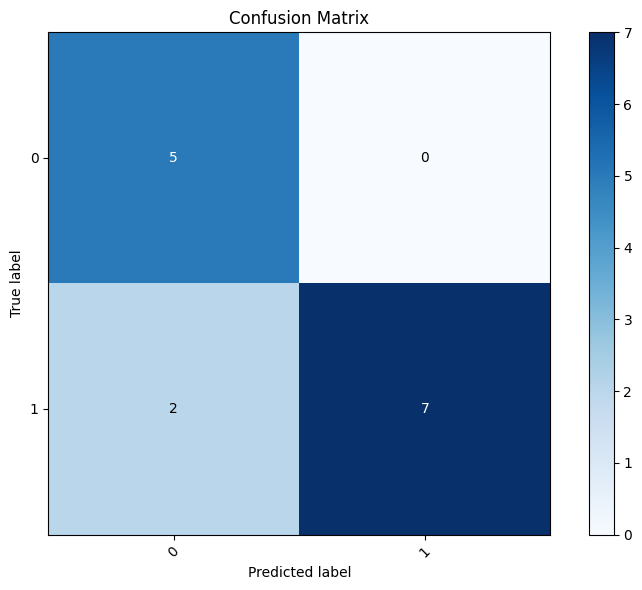

Accuracy: 0.8571428571428571
Class 0:
  precision: 0.7142857142857143
  recall: 1.0
  f1-score: 2.0
  support: 5
Class 1:
  precision: 1.0
  recall: 0.7777777777777778
  f1-score: 2.0
  support: 9


In [7]:
# Assuming y_true and y_pred are defined
y_true = y  # Actual labels
y_pred = predictions  # Predicted labels

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Generate classification report
classification_rep = classification_report(y_true, y_pred)

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=np.unique(y_true))

print(f'Accuracy: {accuracy}')
for cls, metrics in classification_rep.items():
    print(f"Class {cls}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value}")
